## Academic Data Analysis Capstone Project

INFO 698 Notebook
Created 10/7/2025

This notebook for the project contains the KNN Regressor MOdel, and the inital analysis of the data, which will be cleaned, shaled, and reshaped prior to modeling.  

In [117]:
#Libraries for the Project

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
import numpy as np
from matplotlib import pyplot as plt
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

#from sklearn.compose import ColumnTransformer

In [81]:
import pandas as pd
raw_data = pd.read_csv('DataSets/RawData.csv')

#print(raw_data.head())

# Data Load Preparation:
We will clean and modify the data set in preparation for bulding our models

Load the base data set used for analysis and view the head.

In [82]:
#load dataset with null Term GPA excluded
data_set = pd.read_csv('DataSets/RawDataWithStudentsRemoved.csv')

print(data_set.head())

#data_set.dtypes
#data_set.shape

   FakeIdentifier  Age  Gender PrimaryMilitaryAffiliation AcademicCareer  \
0               1   18  Female    No Military Affiliation  Undergraduate   
1               2   72    Male    No Military Affiliation            Law   
2               3   26    Male    No Military Affiliation       Graduate   
3               4   47  Female                    Veteran       Graduate   
4               5   45    Male    No Military Affiliation  Undergraduate   

                          College  NumberofClassesEnrolled  TermGPA  \
0              College of Science                        4     3.75   
1   James E Rogers College of Law                        3     4.00   
2          College of Engineering                        2      NaN   
3       Coll of Ag Life & Env Sci                        2     4.00   
4  College of Information Science                        2     2.00   

   CumulativeGPA  UnitsPassedincludedinGPA  UnitsPassednotincludedinGPA  \
0          3.636                         

We review the count of null values for each feature of the data set.

In [65]:

data_set_nulls = data_set.isnull().sum()
print(data_set_nulls)

FakeIdentifier                    0
Age                               0
Gender                            0
PrimaryMilitaryAffiliation        0
AcademicCareer                    0
College                           0
NumberofClassesEnrolled           0
TermGPA                        7829
CumulativeGPA                  2617
UnitsPassedincludedinGPA          0
UnitsPassednotincludedinGPA       0
UAFullTimePartTime                0
AcademicLevelEndofTerm            0
FirstGenerationFlag               0
AcademicYear                      0
dtype: int64


We remove all rows (observations) where the target feature, *TermGPA* is NULL. 

We do not want to impute these missing values for our analysis.

In [83]:
data_set = data_set.dropna(subset = ['TermGPA'])

Below is acheck to confirm no NULL values remain in the data set.

In [ ]:
#no nulls
data_set_nulls = data_set.isnull().sum()
print(data_set_nulls)

Basic Statistics for the Data Set: Mean, Standard Deviation, and Quantiles

In [ ]:
#mean and standard dev by College

mean_by_college = data_set.groupby('College')['TermGPA'].mean()
print(mean_by_college)

stdev_by_college = data_set.groupby('College')['TermGPA'].std()
print(stdev_by_college)

In [17]:
# mean and quantiles

mean_termgpa = data_set['TermGPA'].mean()
print(mean_termgpa)


#75th percentile
q3_termgpa = np.percentile(data_set['TermGPA'], 50)

print(q3_termgpa)

3.1899030214688042
3.75


Test Train Split and Feature Inclusion for Data

We set the test train split here, and select which columns to exclude in the models for trainings.

In [84]:
#Split the Data Set

# Y target column
target_column = 'TermGPA'
test_percent = 0.20


#data set dropping the target feature
x_features = data_set.drop(['FakeIdentifier' ,
                             #'College',
                             'CumulativeGPA',
                             'UnitsPassedincludedinGPA',
                             'UnitsPassednotincludedinGPA',
                             'TermGPA'],
                               axis = 1)


#encoding categorical features
columns_to_encode = ['Gender',
                      'PrimaryMilitaryAffiliation',
                        'AcademicCareer',
                          'College',
                      'UAFullTimePartTime',
                        'AcademicLevelEndofTerm',
                          'FirstGenerationFlag' 
                          ]

#define our target column on which we make predictions
y_target = data_set[target_column]


#split the data into a 80/20 train test split using the same random seed for consistency
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = test_percent, random_state = 698) 

#encode categorical features, and drop one level to avoid multicolinearity
x_train_encoded = pd.get_dummies(x_train,
                                  columns=columns_to_encode,
                                    drop_first=True,
                                      dtype = int)
x_test_encoded = pd.get_dummies(x_test,
                                 columns=columns_to_encode,
                                 drop_first=True,
                                   dtype = int)
# restore missing features after encoding
x_train_features_encoded_cols = x_train_encoded.columns
x_test_encoded = x_test_encoded.reindex(columns=x_train_features_encoded_cols, fill_value=0)

# K Nearest Neighbors Model Prep


We prepare to build a KNN Regressor Model. The accruacy will be measured via the RMSE and R sqaured. 

These values will be compared to the Random Forest Model, and to Phillip's various regression models. 

In [85]:
#Prepare both numeric and categorical features for scaling or encoding
numeric_features = x_train.select_dtypes(include=['number']).columns

categorical_features = x_train.select_dtypes(include=['category', 'object']).columns


In [86]:
# Scaler for data--KNN model, we need to scale the features for this model since KNN is sensitive to extreme values
scaler = StandardScaler()

In [87]:
#scale (normalize) and fit the numeric training data features
x_train_scaled_numeric = scaler.fit_transform(x_train[numeric_features])
x_train_scaled_numeric_df = pd.DataFrame(x_train_scaled_numeric, columns=numeric_features, index=x_train.index)

#apply same fit scaling to the test data numeric features
x_test_scaled_numeric = scaler.transform(x_test[numeric_features])
x_test_scaled_numeric_df = pd.DataFrame(x_test_scaled_numeric, columns=numeric_features, index=x_test.index)


In [88]:
#one-hot encode the categorical features

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop = 'first')

#fit encoder on training data to ensure all training columns are accounted for when testing
encoder.fit(x_train[categorical_features])

#encode train data categorical features
x_train_encoded_categorical = encoder.fit_transform(x_train[categorical_features])
x_train_encoded_categorical_df = pd.DataFrame(x_train_encoded_categorical, columns=encoder.get_feature_names_out(categorical_features), index=x_train.index)

# Combine train processed features into a data frame
x_train_processed = pd.concat([x_train_scaled_numeric_df, x_train_encoded_categorical_df], axis=1)

#view the trainig data
print("Processed Training Data:")
print(x_train_processed.head())

#encode test data which is already fit to x train features-- do not fit again
x_test_encoded_categorical = encoder.transform(x_test[categorical_features])
x_test_encoded_categorical_df  = pd.DataFrame(x_test_encoded_categorical, columns=encoder.get_feature_names_out(categorical_features), index=x_test.index)

#combine test data (encoded categorical and the scaled numeric)
x_test_processed = pd.concat([x_test_scaled_numeric_df, x_test_encoded_categorical_df], axis=1)

Processed Training Data:
            Age  NumberofClassesEnrolled  AcademicYear  Gender_Male  \
56270 -0.539109                 0.974270     -0.524874          0.0   
21219 -0.649295                -0.473828     -1.130808          0.0   
38914 -0.759480                 0.974270     -0.524874          0.0   
55496 -0.098368                -1.197878      1.292927          0.0   
13089 -0.428924                -0.473828     -1.736742          0.0   

       Gender_Unknown  PrimaryMilitaryAffiliation_Child Dependent  \
56270             0.0                                         0.0   
21219             0.0                                         0.0   
38914             0.0                                         0.0   
55496             0.0                                         0.0   
13089             0.0                                         0.0   

       PrimaryMilitaryAffiliation_Guard Reserve  \
56270                                       0.0   
21219                          

# KNN Models
The data sets are encoded and scaled. They are ready for training and testing the KNN model.
We will perform a K nearest Neighbors Regression.

The initial k value was 5. 


Let's find an optimal k-value which gives the best MSE (and RMSE).

In [89]:
#list of k values, only odd to avoid ties

knn_odd_k_values = [kval for kval in range(1, 26) if kval % 2 != 0]

#loop through each kvalue for training and compare (R)MSE for test data
knn_mse_scores = []
for k in knn_odd_k_values:
    knn_regressor_bestk = KNeighborsRegressor(n_neighbors=k)
    knn_regressor_bestk.fit(x_train_processed, y_train)
    y_pred = knn_regressor_bestk.predict(x_test_processed)
    knn_mse_scores.append(mean_squared_error(y_test, y_pred))

# find and extract the best MSE value

print(min(knn_mse_scores))

best_k_index = np.argmin(knn_mse_scores)
best_k_value = knn_odd_k_values[best_k_index]
print(f"Optimal k value: {best_k_value}")
print(f"Minimum MSE: {knn_mse_scores[best_k_index]}")

1.1821020286718733
Optimal k value: 25
Minimum MSE: 1.1821020286718733


With the optimal k-value extracted, we can run the KNN regressor model to find the RMSe and R Squared for our test set.

In [73]:
# KNN Regressor Model
#Optimal k-value is 15, hardcoded here for efficiency
k_value = 25

# define knn model with number of neighbors
knn_regression_model = KNeighborsRegressor(n_neighbors = k_value)

#fit the knn model to the training data
knn_regression_model.fit(x_train_processed, y_train)

KNeighborsRegressor(n_neighbors=25)

In [74]:
# predict for KNN on the test data

knn_y_pred = knn_regression_model.predict(x_test_processed)
#print(knn_y_pred)

# compare output of model with y test data (MSE)
knn_accuracy = mean_squared_error(y_test, knn_y_pred) 

# calculate the RMSE for KNN
knn_rmse = np.sqrt(knn_accuracy)

# Calculate the R-Squared for the KNN model
knn_rsquared = r2_score(y_test, knn_y_pred)

#View RMSE and R^2
print(f"Root Mean Squared Error (RMSE): {knn_rmse:.2f}")
print(f"R-squared (R2) Score: {knn_rsquared:.2f}")

Root Mean Squared Error (RMSE): 1.09
R-squared (R2) Score: 0.14


### KNN Permutation Importance
We will review the permutation importnace for our KNN Regressor model.

In [75]:
knn_result = permutation_importance(knn_regression_model, x_test_processed, y_test, n_repeats=10,
                                    random_state=698, scoring='neg_mean_squared_error')

sorted_idx = knn_result.importances_mean.argsort()

knn_permutation_importances = pd.Series(knn_result.importances_mean[sorted_idx], index=x_test_encoded.columns[sorted_idx]).sort_values(ascending=False)
print("\nPermutation Importance:")
print(knn_permutation_importances)


# The 'importances_mean' attribute contains the average importance score for each feature
feature_importances = knn_result.importances_mean
feature_importances_std = knn_result.importances_std


Permutation Importance:
AcademicLevelEndofTerm_Senior                              7.126724e-02
Age                                                        2.691092e-02
NumberofClassesEnrolled                                    2.462256e-02
AcademicLevelEndofTerm_Junior                              2.260614e-02
AcademicCareer_Undergraduate                               1.541655e-02
FirstGenerationFlag_Y                                      1.439560e-02
AcademicLevelEndofTerm_Graduate                            1.437207e-02
PrimaryMilitaryAffiliation_No Military Affiliation         1.276179e-02
College_Eller College of Management                        1.206912e-02
College_Undergraduate Education                            1.188966e-02
Gender_Male                                                9.141789e-03
AcademicLevelEndofTerm_Sophomore                           8.852100e-03
College_College of Information Science                     6.827841e-03
AcademicYear                           

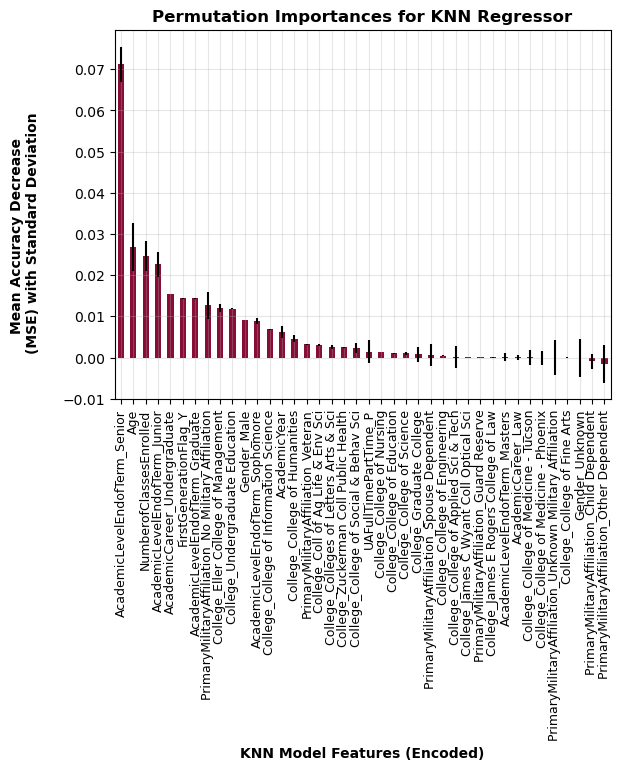

In [79]:
#permutation importance plot code

fig, ax = plt.subplots()
knn_permutation_importances.plot.bar(yerr=knn_result.importances_std, ax=ax, color = "#860E36")
ax.set_title("Permutation Importances for KNN Regressor", fontweight = 'bold')
ax.set_xlabel("KNN Model Features (Encoded)", fontweight = 'bold')
ax.set_ylabel("Mean Accuracy Decrease \n(MSE) with Standard Deviation", fontweight = 'bold')
ax.yaxis.set_label_coords(-0.15, 0.45)
plt.xticks(fontsize=9)
ax.grid(alpha = 0.3)
#fig.tight_layout()
plt.show()

## KNN Results

The KNN Regressor does not perform significantly different from the Random Forest Regressor Model. 
Again, the Cumulative GPA feature, were it included, would dominate the feature importances. 

# Classifier Model Work

We define the features and parameters for the Random Forest Classifier Model. 

We set our *TermGPA* target column, define the test/train split percentage, select which features to remove from the model, and specify the categorical features which require a one-hot encoding for the RF model.

In [110]:
#create GPA binds and labels

#gpa_bins = [0, 2.0, 3.1, 3.4, 3.75, 4.0]
#gpa_bin_labels = ['Warn', 'Pass', 'middle', 'Good', 'Excellent']

gpa_bins = [0, 2.0, 4.0]
gpa_bin_labels = ['Warn', 'Pass']


y_train_binned = pd.cut(y_train, bins=gpa_bins, include_lowest=True, labels=gpa_bin_labels)

#bin y test wiht the same bins as y train
y_test_binned = pd.cut(y_test, bins=gpa_bins, include_lowest=True, labels=gpa_bin_labels)

In [ ]:
#notnormally distributed

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
skew_termgpa = skew(data_set['TermGPA'])

kurtosis_termgpa = kurtosis(data_set['TermGPA'], axis=0, fisher=True, bias=True, nan_policy='propagate')

print(skew_termgpa)
print(kurtosis_termgpa)

sns.histplot(data_set['TermGPA'], kde=True)
plt.title('Histogram of TermGPA')
plt.show()

We set additional model parameters and define the model as RFC. 

We use a consistent random seed parameter (698) where appropriate to ensure consistent behavior when training the model.

In [111]:
# the RF Classifier model parameters and definitions
rfc_metric_options = [accuracy_score, roc_auc_score]
metric = accuracy_score
metric_name = "accuracy"
rfc_depth = 20
rfc_max_features = None # None, sqrt or log2
rfc_min_sample_split = 10
#rfc_criterion = 'squared_error' #criterion{“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error”
rfc_estimators = 200

rfc_model = RandomForestClassifier(n_estimators = rfc_estimators,
                                 max_features = rfc_max_features,
                                    min_samples_split=rfc_min_sample_split,
                                      max_depth = rfc_depth,
                                          random_state=698)


We fit our trained RFC model to our test set. 

Then, we view the score of the model, based on our selected accuracy metric.

In [112]:
#fit the model
rfc_model.fit(x_train_encoded, y_train_binned)

# Predict using test data
y_pred = rfc_model.predict(x_test_encoded) 

    # compare prediction to actual dev/test data
score = metric(y_test_binned, y_pred)
print(f"{metric_name} on test set: {score:.4f}") 

#r_squared = r2_score(y_test, y_pred)
#print(f"r_squared on test set: {r_squared:.4f}") 

accuracy on test set: 0.8256


In [114]:
# confusion matric for RFC model on Test set
rfc_confusion_matrix = confusion_matrix(y_test_binned, y_pred)
print(rfc_confusion_matrix)

rfc_f1_score = f1_score(y_test_binned, y_pred, pos_label = 'Pass')

print(rfc_f1_score)

[[8912  303]
 [1635  264]]
0.901933002732517


In [ ]:
#feature importances:
feature_importances = rfc_model.feature_importances_ 
print(feature_importances)

feature_names = x_train_encoded.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
pd.set_option('display.max_rows', None)
print(feature_importance_df.sort_values(by = 'Importance', ascending = False))

In [ ]:
result = permutation_importance(rfc_model, x_test_encoded, y_test_binned, scoring = 'accuracy', n_repeats=10, random_state=698, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

permutation_importances = pd.Series(result.importances_mean[sorted_idx], index=x_test_encoded.columns[sorted_idx]).sort_values(ascending=False)
print("\nPermutation Importance:")
print(permutation_importances)

KNN Classifier Model: We will employ a KNN model on the same classification problem: a 2.00 Term GPA

In [120]:

# KNN Classifier
#Optimal k-value is 25, hardcoded here for efficiency
k_value = 25

# define knn model with number of neighbors
knn_classifier_model = KNeighborsClassifier(n_neighbors = k_value)

#fit the knn model to the training data
knn_classifier_model.fit(x_train_processed, y_train_binned)

KNeighborsClassifier(n_neighbors=25)

In [ ]:
# predict for KNN Classifier on the test data

knn_c_y_pred = knn_classifier_model.predict(x_test_processed)

In [124]:

#knn classifier confusion matrix
knn_c_confusion_matrix = confusion_matrix(y_test_binned, knn_c_y_pred)
print(knn_c_confusion_matrix)

# KNN classifier F1 Score

knn_c_f1_score = f1_score(y_test_binned, knn_c_y_pred, pos_label = 'Pass')

print(f"KNN F1 on test set: {knn_c_f1_score:.4f}")

# accuracy for the KNN classifier

score = metric(y_test_binned, knn_c_y_pred)
print(f"{metric_name} on test set: {score:.4f}") 

[[9049  166]
 [1756  143]]
KNN F1 on test set: 0.9040
accuracy on test set: 0.8271
